In [ ]:
pip install shap geoshapley

In [ ]:
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel, StationaryKernelMixin, NormalizedKernelMixin, Matern
from sklearn.metrics import mean_absolute_percentage_error, make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score
import geopandas as gpd
import geoshapley
from geoshapley import GeoShapleyExplainer
import warnings
warnings.filterwarnings("ignore")

class GeographicalSimilarityKernel(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    def __init__(self, P_function, sigma_values, epsilon=0.0001):
        self.P_function = P_function
        self.sigma_values = sigma_values
        self.epsilon = epsilon

    def _calculate_similarity(self, u, v):
        u = u[:, np.newaxis, :]
        v = v[np.newaxis, :, :]
        sq_diff = (u - v) ** 2
        E_i = np.exp(-((sq_diff) / (2 * (self.sigma_values**2))))
        return E_i

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X
        E_i = self._calculate_similarity(X, Y)
        S_uv = np.average(E_i, axis=2, weights=self.P_function)
        return S_uv

    def diag(self, X):
        return np.diag(np.ones(X.shape[0])) + self.epsilon

    def is_stationary(self):
        return True

# Define the objective function for Bayesian optimization
def objective(params):
    P_function = np.concatenate((params['P_function'], [0, 0]))
    length_scale = params['length_scale']
    nu = params['nu']
    w = params['w']

    similarity_kernel = GeographicalSimilarityKernel(P_function=P_function, sigma_values=sigma_values)
    kernel = similarity_kernel + w * Matern(length_scale=length_scale, nu=nu)

    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-1, optimizer=None)
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    scores = cross_val_score(gpr, X, y, scoring=neg_rmse_scorer, cv=5)

    loss = -np.mean(scores)
    return {'loss': loss, 'status': STATUS_OK}

# Load data
Berxit = gpd.read_file("/data/leave_data.geojson")
y = Berxit['leave'].values
X_vars = ['to15', 'over65', 'lhosp', 'manu', 'badhealth', 'bornuk', 'x_coord', 'y_coord']
X = Berxit[X_vars].values
sigma_values = np.var(X, axis=0)

# Define the search space
space = {
    'P_function': [hp.uniform(f'p{i}', 0.1, 5) for i in range(len(X_vars) - 2)],
    'length_scale': hp.uniform('length_scale', 0.1, 5),
    'nu': hp.uniform('nu', 0.5, 2.5),
    'w': hp.uniform('w', 0.05, 0.2)
}

# Run Bayesian optimization with Hyperopt
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

# Extract optimized parameters
optimized_P_function = np.concatenate(([best[f'p{i}'] for i in range(len(X_vars) - 2)], [0, 0]))
optimized_length_scale = best['length_scale']
optimized_nu = best['nu']
optimized_w = best['w']

print("Optimized P_function:", optimized_P_function)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized nu:", optimized_nu)
print("Optimized weight w:", optimized_w)

# Train and evaluate the model with optimized parameters
similarity_kernel = GeographicalSimilarityKernel(P_function=optimized_P_function, sigma_values=sigma_values)
kernel = similarity_kernel + optimized_w * Matern(length_scale=optimized_length_scale, nu=optimized_nu)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=2e-2, optimizer=None)
gpr.fit(X, y)

y_pred = gpr.predict(X)
mape = mean_absolute_percentage_error(y, y_pred)
print("MAPE:", mape)

r2 = gpr.score(X, y)
print("R² Score:", r2)

100%|██████████| 50/50 [01:25<00:00,  1.72s/trial, best loss: 6.538350531331706]
Optimized P_function: [3.34646334 3.7456757  1.33430604 1.49639804 0.5240448  0.36624124
 0.         0.        ]
Optimized length_scale: 1.3294259085338733
Optimized nu: 2.0552960518220464
Optimized weight w: 0.0800996364371514
MAPE: 0.020266846717591134
R² Score: 0.988923482337752


In [ ]:
X = Berxit[X_vars]

In [ ]:
import shap
background_X = shap.kmeans(X, 10).data

gpr_explainer = GeoShapleyExplainer(gpr.predict, background_X)

gpr_rslt = gpr_explainer.explain(X,n_jobs=-1)

  0%|          | 0/629 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

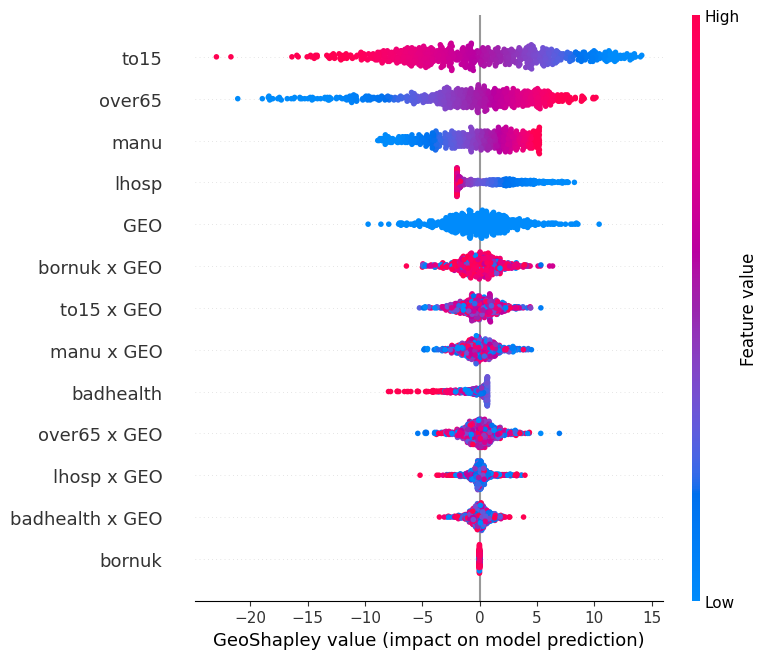

In [ ]:
gpr_rslt.summary_plot(dpi=100)
plt.savefig('/picture/leave_sp.png', dpi=400)

In [ ]:
pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


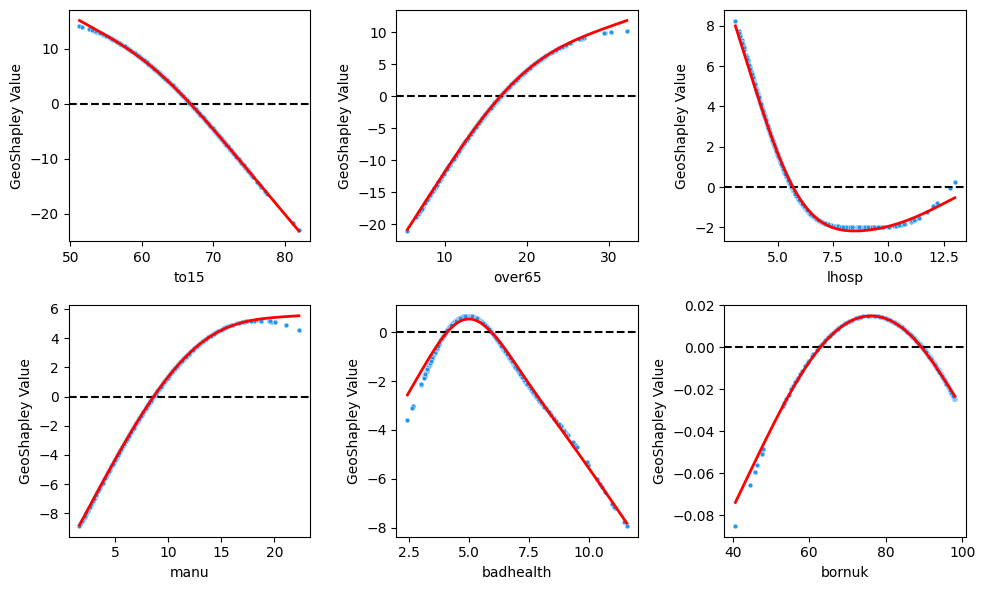

In [ ]:
gpr_rslt.partial_dependence_plots(figsize=(10,6),max_cols=3,gam_curve=True)
plt.savefig('/picture/leave_pdp.png', dpi=400)

In [ ]:
gpr_rslt.summary_statistics()

,min,25%,50%,75%,max,mean,std,abs. mean
to15,-22.943058,-5.226425,-0.474264,4.906272,14.130887,-0.122203,6.893966,5.706285
over65,-21.083235,-3.373980,-0.078478,3.307102,10.144974,-0.873804,5.902778,4.482272
manu,-8.880499,-2.810446,0.308633,2.602619,5.208943,-0.253988,3.614107,2.994881
lhosp,-1.984349,-1.260636,1.344312,3.213782,8.258729,1.339759,2.573027,2.391571
GEO,-9.720612,-1.755438,0.044999,1.785414,10.415241,0.010421,2.779983,2.137487
bornuk x GEO,-6.382170,-1.044004,-0.030525,0.989764,6.361053,-0.005931,1.751024,1.334364
to15 x GEO,-5.245227,-0.898733,-0.025813,0.934179,5.335982,-0.009893,1.525426,1.183787
manu x GEO,-4.861771,-0.869212,-0.017276,0.868810,4.515583,-0.000220,1.424671,1.091160
badhealth,-7.944977,-1.291106,-0.138542,0.527015,0.682432,-0.651888,1.509048,1.089603
over65 x GEO,-5.391613,-0.777984,-0.019071,0.806165,6.948870,0.005404,1.462304,1.068993


In [ ]:
shap_values = gpr_rslt.geoshap_to_shap()

In [ ]:
X_names = ['to15','over65','lhosp','manu','badhealth','bornuk']

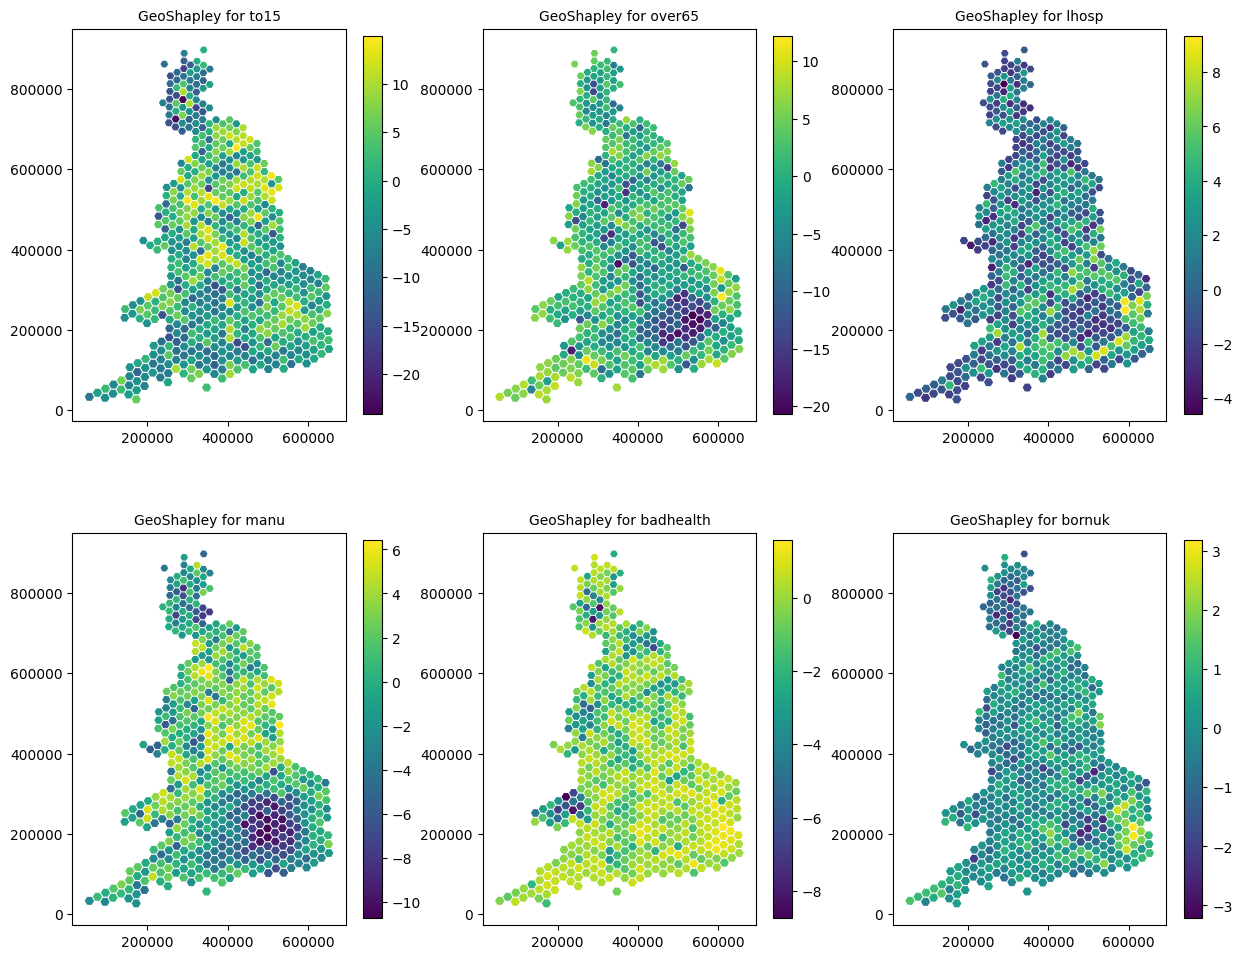

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(15,12))

for j in range(len(X_names)):
    ax = ax.ravel()
    Berxit.plot(ax=ax[j],column = shap_values[:,j],legend=True,
                 cmap='viridis', legend_kwds={'shrink': 0.9})
    ax[j].set_title("GeoShapley for " + X_names[j],fontsize=10)

plt.savefig('/picture/leave_svc.png', dpi=400)